__Лабораторная работа №3. Регрессия__

*Выполнил: Билинский Норгей, группа 932328*

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1>

In [ ]:
# !pip install opendatasets
# !pip install bayesian-optimization


In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold

from bayes_opt import BayesianOptimization

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from torch.utils.data import DataLoader, TensorDataset, random_split


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных</h1>

```
The feature set includes:
-Cement
-Blast Furnace Slag
-Fly Ash
-Water
-Super-plasticizer
-Coarse Aggregate
-Fine Aggregate
-Age

The target set is:
-Strength of the Cement
```

In [ ]:
dataset_path = Path('bike-rental-hour', 'bike_rental_hour.csv')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/hamzajabbarkhan/bike-rental-hour')

df = pd.read_csv(dataset_path)
df.columns = df.columns.str.replace(' ', '', regex=False)
df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')
df.set_index(['dteday', 'instant'], inplace=True)
df = df.drop(columns=['registered', 'atemp', 'casual'])
df


season  yr  mnth  hr  holiday  weekday  workingday  \
dteday     instant                                                       
2011-01-01 1             1   0     1   0        0        6           0   
           2             1   0     1   1        0        6           0   
           3             1   0     1   2        0        6           0   
           4             1   0     1   3        0        6           0   
           5             1   0     1   4        0        6           0   
...                    ...  ..   ...  ..      ...      ...         ...   
2012-12-31 17375         1   1    12  19        0        1           1   
           17376         1   1    12  20        0        1           1   
           17377         1   1    12  21        0        1           1   
           17378         1   1    12  22        0        1           1   
           17379         1   1    12  23        0        1           1   

                    weathersit  temp   hum  windspeed  cnt  
dteday     instant                                          
2011-01-01 1                 1  0.24  0.81     0.0000   16  
           2                 1  0.22  0.80     0.0000   40  
           3                 1  0.22  0.80     0.0000   32  
           4                 1  0.24  0.75     0.0000   13  
           5                 1  0.24  0.75     0.0000    1  
...                        ...   ...   ...        ...  ...  
2012-12-31 17375             2  0.26  0.60     0.1642  119  
           17376             2  0.26  0.60     0.1642   89  
           17377             1  0.26  0.60     0.1642   90  
           17378             1  0.26  0.56     0.1343   61  
           17379             1  0.26  0.65     0.1343   49  

[17379 rows x 12 columns]

In [ ]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
for column in df.columns:
    missing_count = df[column].isnull().sum()
    print(f"{column}: {missing_count}")


Размер датасета: (17379, 12)
Пропущенные значения:
season: 0
yr: 0
mnth: 0
hr: 0
holiday: 0
weekday: 0
workingday: 0
weathersit: 0
temp: 0
hum: 0
windspeed: 0
cnt: 0


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> EDA </h1>

In [ ]:
df.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
season,17379.000000,2.501640,1.106918,1.000000,2.000000,3.000000,3.000000,4.000000
yr,17379.000000,0.502561,0.500008,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,17379.000000,6.537775,3.438776,1.000000,4.000000,7.000000,10.000000,12.000000
hr,17379.000000,11.546752,6.914405,0.000000,6.000000,12.000000,18.000000,23.000000
holiday,17379.000000,0.028770,0.167165,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,17379.000000,3.003683,2.005771,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,17379.000000,0.682721,0.465431,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,17379.000000,1.425283,0.639357,1.000000,1.000000,1.000000,2.000000,4.000000
temp,17379.000000,0.496987,0.192556,0.020000,0.340000,0.500000,0.660000,1.000000
hum,17379.000000,0.627229,0.192930,0.000000,0.480000,0.630000,0.780000,1.000000


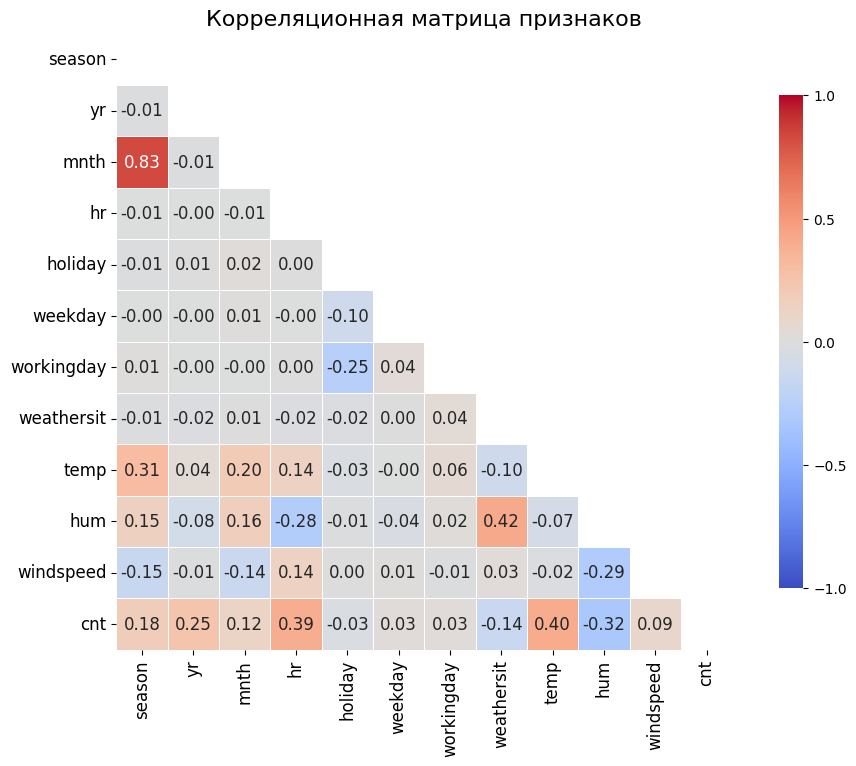

In [ ]:
corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot_kws={"size": 12}, fmt=".2f",
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})

plt.title('Корреляционная матрица признаков', size=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


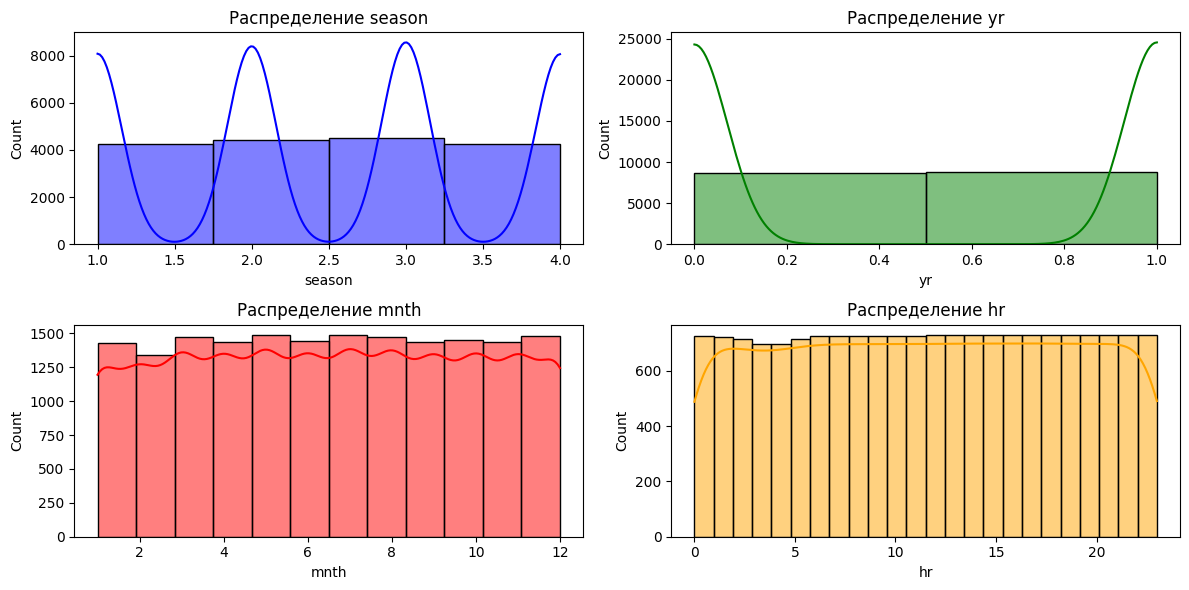

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['season'], bins=4, kde=True, color='blue')
plt.title('Распределение season')

plt.subplot(2, 2, 2)
sns.histplot(df['yr'], bins=2, kde=True, color='green')
plt.title('Распределение yr')

plt.subplot(2, 2, 3)
sns.histplot(df['mnth'], bins=12, kde=True, color='red')
plt.title('Распределение mnth')

plt.subplot(2, 2, 4)
sns.histplot(df['hr'], bins=24, kde=True, color='orange')
plt.title('Распределение hr')

plt.tight_layout()
plt.show()


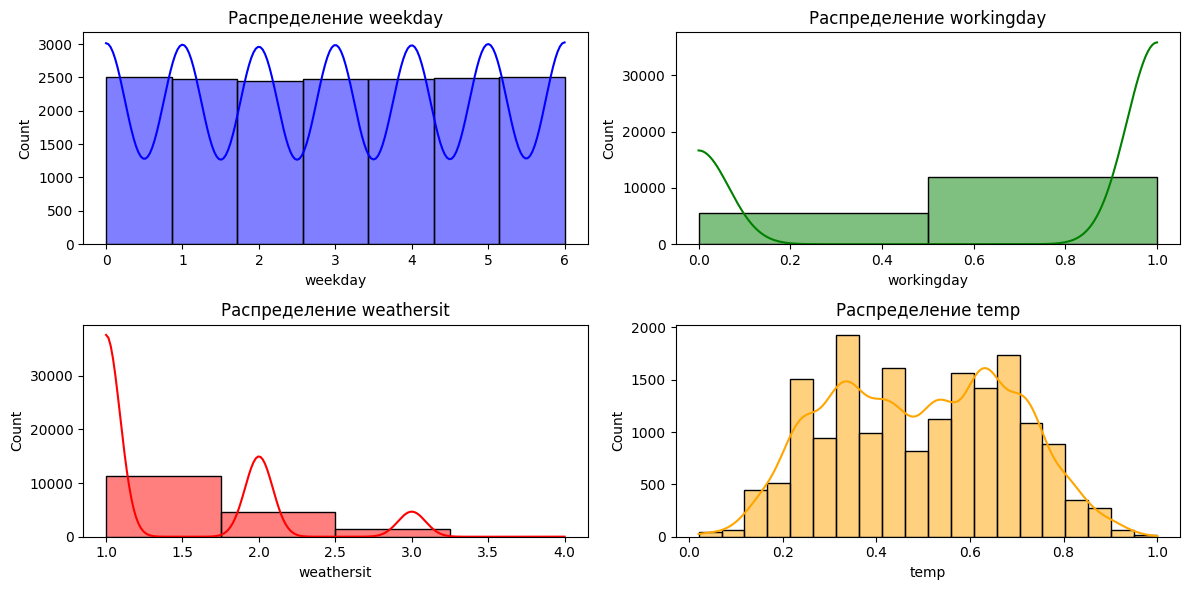

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['weekday'], bins=7, kde=True, color='blue')
plt.title('Распределение weekday')

plt.subplot(2, 2, 2)
sns.histplot(df['workingday'], bins=2, kde=True, color='green')
plt.title('Распределение workingday')

plt.subplot(2, 2, 3)
sns.histplot(df['weathersit'], bins=4, kde=True, color='red')
plt.title('Распределение weathersit')

plt.subplot(2, 2, 4)
sns.histplot(df['temp'], bins=20, kde=True, color='orange')
plt.title('Распределение temp')

plt.tight_layout()
plt.show()


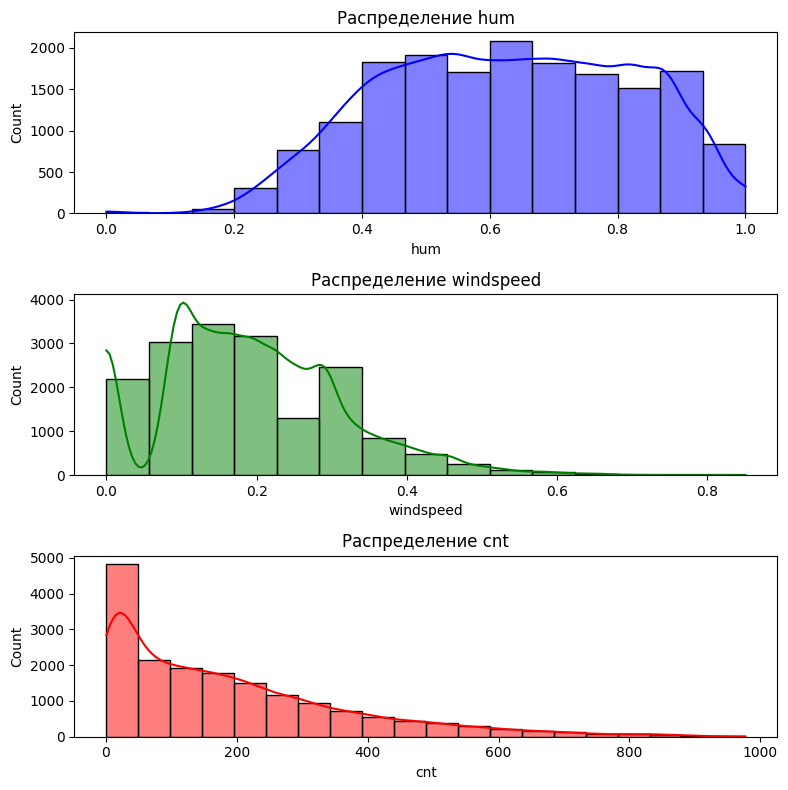

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
sns.histplot(df['hum'], bins=15, kde=True, color='blue')
plt.title('Распределение hum')

plt.subplot(3, 1, 2)
sns.histplot(df['windspeed'], bins=15, kde=True, color='green')
plt.title('Распределение windspeed')

plt.subplot(3, 1, 3)
sns.histplot(df['cnt'], bins=20, kde=True, color='red')
plt.title('Распределение cnt')

plt.tight_layout()
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Преобразование и подготовка данных</h1>

In [ ]:
X = df.drop(columns=['cnt']).copy()
y = df['cnt'].copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Размер X_train: {len(X_train)}")
print(f"Размер X_test: {len(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

# Преобразование данных в numpy массивы
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test


Размер X_train: 13903
Размер X_test: 3476
Размер y_train: 13903
Размер y_test: 3476


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение моделей</h1>

### <h1 id="aa" style="color:white;background:#009900;padding:8px;border-radius:8px;font-family:newtimeroman;"> TensorFlow</h1>

#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train_np.shape[1],)))
model.add(Dense(250, activation='relu')) # скрытый слой
model.add(Dense(100, activation='relu')) # скрытый слой
model.add(Dense(50, activation='relu')) # скрытый слой
model.add(Dense(1, activation='linear')) # выходной слой с линейной функцией активации
model.compile(loss='mean_squared_error', # в качестве функции потерь используем mse
              optimizer='adam',
              metrics=['mae', 'mse'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 44259.0547 - mae: 152.1746 - mse: 44259.0547 - val_loss: 21288.5039 - val_mae: 107.7562 - val_mse: 21288.5039
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19964.6816 - mae: 104.1295 - mse: 19964.6816 - val_loss: 20125.9375 - val_mae: 106.9302 - val_mse: 20125.9375
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20146.3262 - mae: 104.1328 - mse: 20146.3262 - val_loss: 19279.3867 - val_mae: 102.9514 - val_mse: 19279.3867
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19309.8555 - mae: 101.4234 - mse: 19309.8555 - val_loss: 18673.7734 - val_mae: 93.1234 - val_mse: 18673.7734
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17782.2656 - mae: 96.2350 - mse: 17782.2656 - val_loss: 17124.1777 - val_mae: 96.0393 - val_mse: 17124.1777
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17038.6230 - mae: 93.7784 - mse: 17038.6230 - val_loss: 15741.8242 - val_mae: 85.2170 - val_m

In [ ]:
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 31.151
MAPE: 37.11%
RMSE: 49.385
R2: 0.923


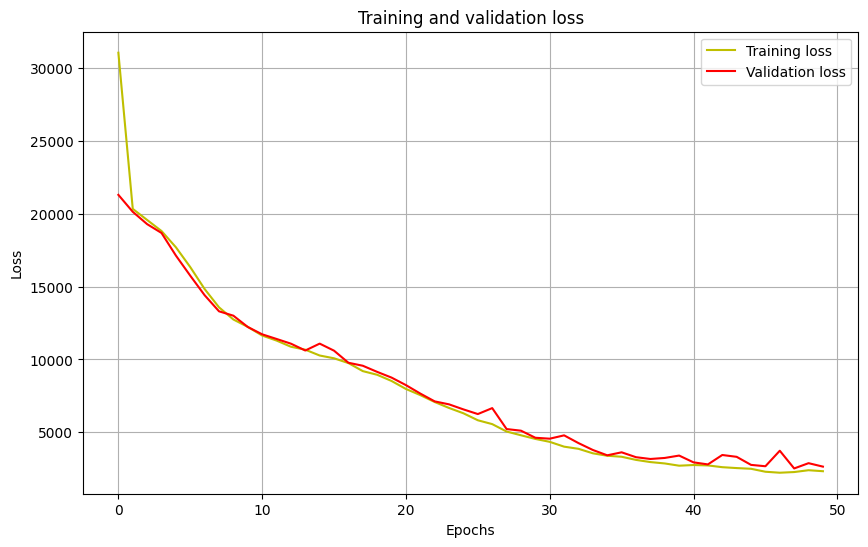

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Подбор гиперапарметров через BayesianOptimization</h1>

In [ ]:
# Функция для маппинга числового значения на активацию
def map_activation(val):
    activations = ['relu', 'tanh', 'sigmoid']
    return activations[int(val)]


# Функция для генерации списка числа нейронов на слоях
def generate_neurons_list(num_layers, first_layer_neurons):
    neurons_list = [first_layer_neurons]  #1-ый скрытый слой

    for i in range(1, int(num_layers)):
        # Уменьшаем количество нейронов на каждом следующем слое в 2 раза
        previous_layer_neurons = neurons_list[-1]
        next_layer_neurons = max(1, int(previous_layer_neurons / 2))
        neurons_list.append(next_layer_neurons)  # Добавляем в список количество нейронов следующего слоя

    return neurons_list


# Функция для создания модели
def create_model(lr, neurons_list, activation, num_layers,
                 l1_strength, l2_strength, dropout_rate):
    model = Sequential()

    # Добавляем первый слой
    model.add(Input(shape=(X_train_np.shape[1],)))

    # Добавляем скрытые слои с регуляризацией Elastic Net
    for i in range(0, int(num_layers)):
        model.add(Dense(int(neurons_list[i]), activation=activation,
                        kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
        model.add(Dropout(dropout_rate))  # Добавляем слой Dropout

    # Добавляем выходной слой с линейной активацией
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


# Функция для кросс-валидации
def keras_cv_model(lr, first_layer_neurons, activation, num_layers,
                   l1_strength, l2_strength, dropout_rate):
    # Разделение данных на 5 фолдов с перемешиванием
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []  # Список для хранения оценок кросс-валидации

    # Генерация списка нейронов на слоях
    neurons_list = generate_neurons_list(int(num_layers), int(first_layer_neurons))

    # Проходим через каждый фолд
    for train_idx, val_idx in kfold.split(X_train_np):
        # Преобразуем индексы в numpy массивы
        train_idx = np.array(train_idx)  # Индексы для обучающей выборки
        val_idx = np.array(val_idx)  # Индексы для валидационной выборки

        # Преобразование индекса активационной функции в строку
        activation_str = map_activation(activation)

        model = create_model(lr, neurons_list, activation_str, int(num_layers),
                             l1_strength, l2_strength, dropout_rate)

        # Настройка ранней остановки для предотвращения переобучения
        # Прекращает обучение, если валидационная ошибка не улучшается в течение 5 эпох,
        # и восстанавливает веса модели, которые дали наименьшую валидационную ошибку.
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_train_np[train_idx], y_train_np[train_idx], epochs=25, batch_size=256,
                  validation_data=(X_train_np[val_idx], y_train_np[val_idx]),
                  callbacks=[early_stopping], verbose=0)  #verbose=0, чтобы подавить вывод

        y_pred = model.predict(X_train_np[val_idx])
        cv_scores.append(mean_squared_error(y_train_np[val_idx], y_pred))

    return -np.mean(cv_scores)


In [ ]:
# Оптимизация гиперпараметров с помощью Bayesian Optimization
pbounds = {
    'lr': (1e-5, 1e-2),  # Скорость обучения
    'first_layer_neurons': (32, 256),  # Количество нейронов на первом скрытом слое
    'activation': (0, 2),  # Функции активации скрытых слоёв 0: relu, 1: tanh, 2: sigmoid
    'num_layers': (1, 5),  # Количество слоев
    'l1_strength': (0, 0.3),  # Сила L1 регуляризации
    'l2_strength': (0, 0.3),  # Сила L2 регуляризации
    'dropout_rate': (0.0, 0.25),  # Процент дропаута (от 0% до 25%)
}

optimizer = BayesianOptimization(
    f=keras_cv_model,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=10, n_iter=30)

# Получение лучших гиперпараметров
best_params = optimizer.max['params']

best_lr = best_params['lr']
best_first_layer_neurons = int(best_params['first_layer_neurons'])
best_activation = int(best_params['activation'])
best_num_layers = int(best_params['num_layers'])
best_l1_strength = best_params['l1_strength']
best_l2_strength = best_params['l2_strength']
best_dropout_rate = best_params['dropout_rate']
best_neurons_list = generate_neurons_list(best_num_layers, best_first_layer_neurons)

print("Лучшие гиперпараметры:")
print(f"Learning Rate: {best_lr:.5f}")
print(f"First layer neurons: {best_first_layer_neurons}")
print(f"Number of Layers: {best_num_layers}")
print(f"Neurons in Each Layer: {best_neurons_list}")
print(f"Activation Function: {map_activation(best_activation)}")
print(f"L1 Regularization Strength: {best_l1_strength:.2f}")
print(f"L2 Regularization Strength: {best_l2_strength:.2f}")
print(f"Dropout Rate: {best_dropout_rate:.2f}")


|   iter    |  target   | activa... | dropou... | first_... | l1_str... | l2_str... |    lr     | num_la... |
-------------------------------------------------------------------------------------------------------------
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
| 1         | -2.124e+0 | 0.7491    | 0.2377    | 196.0     | 0.1796    | 0.04681   | 0.001568  | 1.232     |
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
| 2         | -1.494e+0 | 1.732     | 0.1503    | 190.6     | 0.006175  | 0.291     | 0.008326  | 1.849     |
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━

In [ ]:
# Обучение модели с лучшими гиперпараметрами
best_model = create_model(
    lr=best_lr,
    neurons_list=best_neurons_list,
    activation=map_activation(best_activation),
    num_layers=best_num_layers,
    l1_strength=best_l1_strength,
    l2_strength=best_l2_strength,
    dropout_rate=best_dropout_rate
)

# Обучение модели на всей обучающей выборке
history_best = best_model.fit(X_train_np, y_train_np, epochs=200, batch_size=256,
                              validation_split=0.2, verbose=0)

# Оценка на отложенной тестовой выборке
y_pred = best_model.predict(X_test_np)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 25.962
MAPE: 35.84%
RMSE: 42.125
R2: 0.944


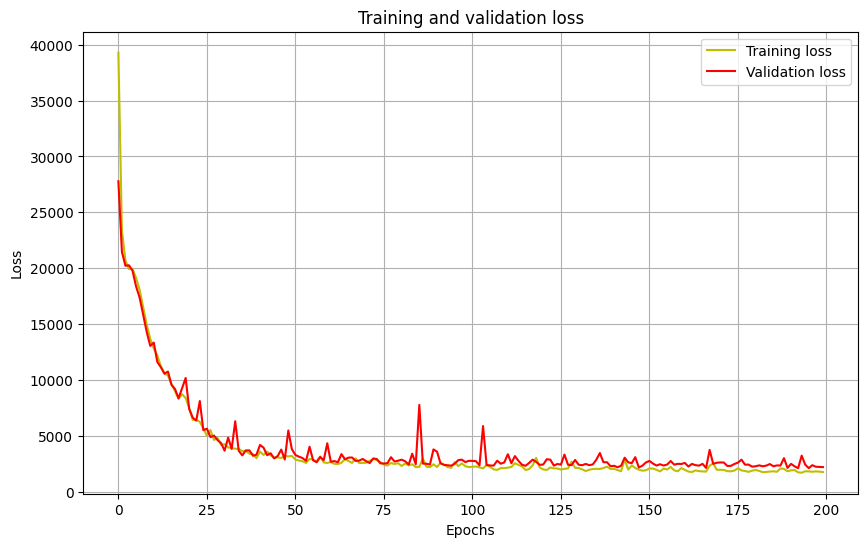

In [ ]:
loss = history_best.history['loss']
val_loss = history_best.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### <h1 id="aa" style="color:white;background:#009900;padding:8px;border-radius:8px;font-family:newtimeroman;"> PyTorch</h1>

#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

In [ ]:
# Определение модели
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 250)  # Первый скрытый слой
        self.fc2 = nn.Linear(250, 100)         # Второй скрытый слой
        self.fc3 = nn.Linear(100, 50)          # Третий скрытый слой
        self.fc4 = nn.Linear(50, 1)            # Выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Линейная активация на выходе
        return x

# Инициализация модели
input_size = X_train_np.shape[1]
model = RegressionModel(input_size)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()  # Среднеквадратичная ошибка
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)

# Разделение на тренировочную и валидационную выборки (80% на обучение, 20% на валидацию)
train_size = int(0.8 * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_tensor, y_train_tensor), [train_size, val_size])

# Создаем DataLoader для батчей
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Логирование потерь на каждой эпохе
train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Логирование потерь на тренировке

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))  # Логирование потерь на валидации

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")


Epoch 1/50, Loss: 34005.88888234105, Val Loss: 21354.98797817888
Epoch 2/50, Loss: 20861.551457547594, Val Loss: 18959.914298221982
Epoch 3/50, Loss: 19705.642200689206, Val Loss: 18311.411503232757
Epoch 4/50, Loss: 18956.27880859375, Val Loss: 17410.283466909124
Epoch 5/50, Loss: 17923.61342717313, Val Loss: 16436.777427936424
Epoch 6/50, Loss: 16783.38050088115, Val Loss: 15136.9273358926
Epoch 7/50, Loss: 15447.682285352685, Val Loss: 13884.695851293103
Epoch 8/50, Loss: 14255.619812713272, Val Loss: 12929.932241154813
Epoch 9/50, Loss: 13313.077903309088, Val Loss: 12661.625432156969
Epoch 10/50, Loss: 12467.57182504939, Val Loss: 11439.829960264009
Epoch 11/50, Loss: 11827.808837890625, Val Loss: 11003.961479099318
Epoch 12/50, Loss: 11297.243124775503, Val Loss: 10795.271734128053
Epoch 13/50, Loss: 11050.027390052532, Val Loss: 10070.84477426814
Epoch 14/50, Loss: 10494.250063139816, Val Loss: 9805.692764457615
Epoch 15/50, Loss: 10219.058519385328, Val Loss: 9600.172068628772


In [ ]:
# Прогнозирование на тестовых данных
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

model.eval()  # Переключаем модель в режим оценки
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()  # Прогнозы модели (выходной тензор преобразуем в numpy)

# Вычисление метрик
mae = mean_absolute_error(y_test_np, predictions)
mape = mean_absolute_percentage_error(y_test_np, predictions) * 100
rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
r2 = r2_score(y_test_np, predictions)

# Вывод метрик
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


MAE: 31.593
MAPE: 39.09%
RMSE: 49.310
R2: 0.923


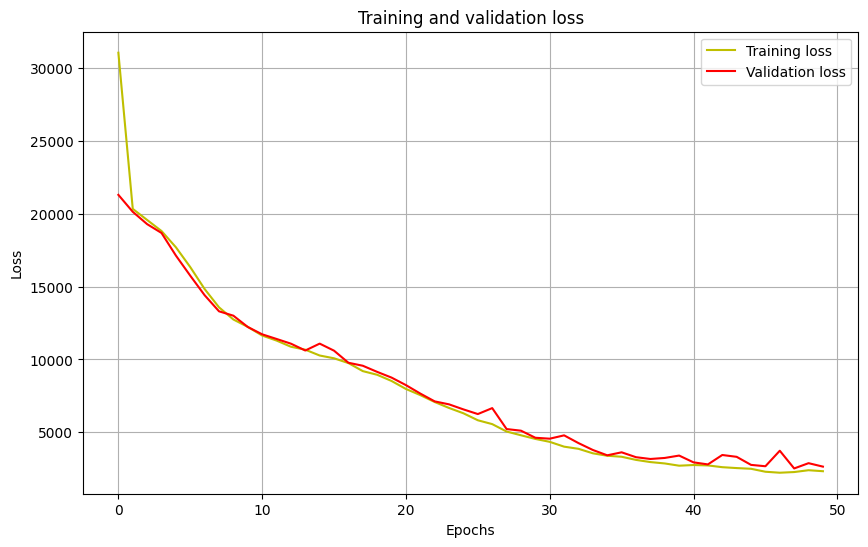

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Функция для маппинга числового значения на активацию
def map_activation(val):
    activations = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
    return activations[int(val)]


# Функция для генерации списка числа нейронов на слоях
def generate_neurons_list(num_layers, first_layer_neurons):
    if first_layer_neurons <= 0:
        raise ValueError("Первый слой должен иметь положительное количество нейронов.")

    neurons_list = [first_layer_neurons]
    for i in range(1, int(num_layers)):
        previous_layer_neurons = neurons_list[-1]
        next_layer_neurons = max(1, int(previous_layer_neurons / 2))
        neurons_list.append(next_layer_neurons)

    return neurons_list


# Модель на PyTorch
class RegressionModel(nn.Module):
    def __init__(self, neurons_list, activation, l1_strength, l2_strength, dropout_rate):
        super(RegressionModel, self).__init__()
        layers = []
        for i in range(len(neurons_list) - 1):
            layers.append(nn.Linear(neurons_list[i], neurons_list[i + 1]))
            layers.append(activation)
            if l1_strength > 0 or l2_strength > 0:
                layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(neurons_list[-1], 1))  # Выходной слой
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# Функция создания модели
def create_model(lr, neurons_list, activation, num_layers, l1_strength, l2_strength, dropout_rate):
    model = RegressionModel(neurons_list, activation, l1_strength, l2_strength, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer


# Функция для кросс-валидации
def pytorch_cv_model(lr, first_layer_neurons, activation, num_layers, l1_strength, l2_strength, dropout_rate):
    neurons_list = generate_neurons_list(int(num_layers), int(first_layer_neurons))
    activation_fn = map_activation(activation)

    # K-Fold кросс-валидация
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kfold.split(X_train_np):
        # Преобразование данных в тензоры
        train_dataset = TensorDataset(torch.tensor(X_train_np[train_idx], dtype=torch.float32),
                                      torch.tensor(y_train_np[train_idx], dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_train_np[val_idx], dtype=torch.float32),
                                    torch.tensor(y_train_np[val_idx], dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

        model, optimizer = create_model(lr, neurons_list, activation_fn, num_layers, l1_strength, l2_strength, dropout_rate)
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0

        for epoch in range(25):  # Ограничение на 25 эпох
            model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Валидация
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets.view(-1, 1))
                    val_loss += loss.item()

            val_loss /= len(val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter > patience:
                break

        model.load_state_dict(best_model_state)  # Восстановление лучших весов
        y_pred = model(torch.tensor(X_train_np[val_idx], dtype=torch.float32)).detach().numpy()
        cv_scores.append(mean_squared_error(y_train_np[val_idx], y_pred))

    return -np.mean(cv_scores)


In [ ]:
# Оптимизация гиперпараметров с помощью Bayesian Optimization
pbounds = {
    'lr': (1e-5, 1e-2),
    'first_layer_neurons': (32, 256),
    'activation': (0, 2),
    'num_layers': (1, 5),
    'l1_strength': (0, 0.3),
    'l2_strength': (0, 0.3),
    'dropout_rate': (0.0, 0.25),
}

optimizer = BayesianOptimization(f=pytorch_cv_model, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

# Получение лучших гиперпараметров
best_params = optimizer.max['params']
best_lr = best_params['lr']
best_first_layer_neurons = int(best_params['first_layer_neurons'])
best_activation = int(best_params['activation'])
best_num_layers = int(best_params['num_layers'])
best_l1_strength = best_params['l1_strength']
best_l2_strength = best_params['l2_strength']
best_dropout_rate = best_params['dropout_rate']
best_neurons_list = generate_neurons_list(best_num_layers, best_first_layer_neurons)

print("Лучшие гиперпараметры:")
print(f"Learning Rate: {best_lr:.5f}")
print(f"First layer neurons: {best_first_layer_neurons}")
print(f"Number of Layers: {best_num_layers}")
print(f"Neurons in Each Layer: {best_neurons_list}")
print(f"Activation Function: {map_activation(best_activation)}")
print(f"L1 Regularization Strength: {best_l1_strength:.2f}")
print(f"L2 Regularization Strength: {best_l2_strength:.2f}")
print(f"Dropout Rate: {best_dropout_rate:.2f}")


|   iter    |  target   | activa... | dropou... | first_... | l1_str... | l2_str... |    lr     | num_la... |
-------------------------------------------------------------------------------------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x11 and 195x1)

In [ ]:
# Обучение модели с лучшими гиперпараметрами
best_model, best_optimizer = create_model(
    lr=best_lr,
    neurons_list=best_neurons_list,
    activation=map_activation(best_activation),
    num_layers=best_num_layers,
    l1_strength=best_l1_strength,
    l2_strength=best_l2_strength,
    dropout_rate=best_dropout_rate
)

criterion = nn.MSELoss()
train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(y_train_np, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

train_losses = []
val_losses = []

for epoch in range(200):
    best_model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        best_optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        best_optimizer.step()
        train_loss += loss.item()

    # Средняя потеря для тренировочной выборки
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Валидационная потеря
    best_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()

    # Средняя потеря для валидационной выборки
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


# Оценка на тестовой выборке
best_model.eval()
with torch.no_grad():
    y_pred = best_model(torch.tensor(X_test_np, dtype=torch.float32)).numpy()

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test_np, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'y', label='Training loss')
plt.plot(val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
